# Why not Square Error for Classification?

<br/>John Mount
<br/>[Win Vector LLC](https://win-vector.com)
<br/>August 31, 2020


[Win Vector LLC](https://win-vector.com) has been developing and delivering a lot of ["statistics, machine learning, and data science for engineers" intensives](https://win-vector.com/training-overview/) in the past few years.

These are bootcamps, or workshops, designed to help software engineers become more comfortable with machine learning and artificial intelligence tools. The current thinking is: not every engineer is going to become a machine learning scientist, but most engineers are going to be working on projects with machine learning scientists. There are a great number of quality *passive* courses already out there, and we have found that the engineers are left desiring the ability to work with an expert consultant on an example project, and to be able to ask critical questions about what they are learning.

Our workshops have been transformative for engineers, and have taught *us* a lot about what are the basic critical questions about our field.

The teacher is moved from having an *opinion* on what concepts and alternatives are needed to rapidly master the material, to having seen what works and what open questions cause discomfort.

For example we teach, as we also have in our book [*Practical Data Science with R*](http://practicaldatascience.com) that [*statistical deviance*](https://en.wikipedia.org/wiki/Deviance_(statistics)) (or equivalently [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) style methods) is an excellent tool for evaluating probability models. In *late* evaluation we find it more useful than AUC (which is very useful in *early* model assessment).  Deviance, like AUC, doesn't require the needless and wasteful conversion of a probability model to a mere [decision rule](https://win-vector.com/2020/08/07/dont-use-classification-rules-for-classification-problems/), as evaluation metrics such as precision require.

When teaching something seemingly exotic like deviance we often get asked the following reasonable question:

> Why can't you just use square error?

Frankly that is a brilliant question reflecting experience from ordinary regression. This question deserves a prepared crisp answer. Let's work an example of why square error isn't a great metrics for probability models.

Let's first set up our discussion. We are trying to predict the probability of an occurrence. This is a classification problem, but we want a useful numeric score or even probability instead of a mere [decision rule](https://win-vector.com/2020/08/07/dont-use-classification-rules-for-classification-problems/). 

Our first issue is: if we treat a probability model naively as a regression we likely build a model that might produce numeric predictions outside of the rage zero to one. We want to work around the problem that from a square-loss point of view a prediction of `3.0` for a positive training event is going to be scored as being *worse* that predicting a probablity of `0.7`.

The traditional method to get our predictions into the range zero to one is to use a generalized linear model, which allows a transform to be applied to predictions.

One very favorable transform is the "sigmoid", as used in logistic regression. The sigmoid can be defined in Python as follows.

In [1]:
def sigmoid(x):
    return 1/(1 + exp(-x))

The sigmoid maps the real numbers into the open range zero to one as follows.

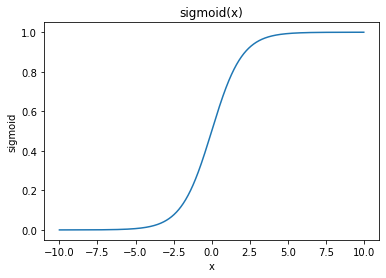

In [2]:
import numpy
import pandas
import seaborn

d = pandas.DataFrame({
    'x': numpy.arange(
        start=-10, 
        stop=10, 
        step=0.01)
})

d['sigmoid'] = 1/(1 + numpy.exp(-d.x))

ax = seaborn.lineplot(
    x='x', 
    y='sigmoid', 
    data=d)
_ = ax.set_title('sigmoid(x)')

Throughout this note `y` will be the dependent variable we are trying to predict, it is `1` for the in-class or positive examples, and `0` for out-of-class or negative examples. Our explanatory variable or vector is `x`, and our model parameters are `b`. In all cases our prediction is `sigmoid(b * x)`, which we sometimes just call "`predication`". Think of `b * x` a shorthand for the more general "&beta;0 + &beta; . x" where &beta; and x are vectors. Sometimes we will add a subscript-`i` with `y_i` being the `i`-th dependent variable, `x_i` being the `i`-th explanatory vector, and `prediction_i = sigmoid(b * x_i)`.

Our advice is: deviance is the natural loss or error-model for this generalized linear model (also called logistic regression)  [For some great notes please see here](https://win-vector.com/2011/09/14/the-simpler-derivation-of-logistic-regression/)).

The question remains: why is a square-error loss not good in this situation? We usually don't have time or space to show why, but let's do that here.

First let's import `sympy` to allow symbolic calculations and set up some symbols to calculate over.

In [3]:
from sympy import *

In [4]:
x, y, b, s = symbols("x y b s")

As an aside, the sigmoid is a wonderful function obeying a number of very useful identities, some of which make it easier to reason about working with loss functions involving the sigmoid function. For example `sigmoid(-x) == 1 - sigmoid(x)`, which is easily confirmed as follows.


In [5]:
simplify( 
    sigmoid(-x)  -  
    (1 - sigmoid(x)) 
)

0

The derivatives (with respect to `x`) of the sigmoid function obey some really neat algebraic identities.

  * `(sigmoid(b * x))' = b * sigmoid(b * x) * (1 - sigmoid(b * x))`
  * `(sigmoid(b * x))'' = b**2 * sigmoid(b * x) * (1 - 2 * sigmoid(b * x)) * (1 - sigmoid(b * x))`
  
We can confirm these using `sympy`.

For the first derivative with respect to `x` we have:

In [6]:
symbolic_deriv_1 = b * s * (1 - s)
symbolic_deriv_1

b*s*(1 - s)

And we can check this is equal to the value claimed.

In [7]:
simplify( 
    diff(sigmoid(b * x), x) -   
    symbolic_deriv_1.subs({s: sigmoid(b * x)}) 
)

0

For the second derivative the check is similarly easy.

In [8]:
symbolic_deriv_2 = b**2 * s * (1 - 2 * s) * (1 - s)
symbolic_deriv_2

b**2*s*(1 - 2*s)*(1 - s)

In [9]:
simplify( 
    diff(diff(sigmoid(b * x), x), x)  -
    symbolic_deriv_2.subs({s: sigmoid(b * x)}) 
)

0

Throughout this note we will be solving for good models by specifying a criticism of a model and using an optimizer. In general criticisms are called "loss functions" and we design these loss functions so that a modeling solution that minimizes loss has good properties. So the loss function is roughly how we specify what we want (a good model) and an optimizer is how we find such a model.

Now let's take a look at what happens if we incorporate our sigmoid-prediction into a simple square loss. Square loss *is* the natural loss for general numeric regression problems, but turns out not to be the most natural choice for probability models.

In [10]:
square_loss = (y - sigmoid(b * x))**2
square_loss

(y - 1/(1 + exp(-b*x)))**2

In [11]:
square_loss_deriv_1 = simplify(diff(square_loss, x))
square_loss_deriv_1

-2*b*(y*(exp(b*x) + 1) - exp(b*x))*exp(b*x)/(exp(b*x) + 1)**3

This complicated looking loss is equivalent to the simpler form `-2 * b * (y - s) * s * (1 - s)`, which we can confirm as follows.

In [12]:
simplify( 
    square_loss_deriv_1  -  
    ( - 2 * b * (y - sigmoid(b * x)) * sigmoid(b * x) * (1 - sigmoid(b * x))) 
)

0

Think of the above loss as the loss at a single training data point. To get total training loss we would then sum the above loss function over all training examples, substituting out `x` to get new predictions and `y` to get new explanatory examples to compare to.

We expect the loss to be minimized somewhere the above first derivative is zero (when summed across all training examples). The above first derivative being zero can be read as: "the sum of `y_i` over the training data is identical to the sum of `prediction_i = sigmoid(b * x_i)` over the training data under the data weighting of `sigmoid(b * x_i) * (1 - sigmoid(b * x_i))`.

This is already an issue.

We want, for a proper regression, to have `sum_i y_i = sum_i prediction_i`, which is the usual "predictor is unbiased on the training data" condition. We don't particularly care if the balance condition holds for some odd re-weighting of the training data, which is what was true for the square loss.

So the square loss is optimizing something, but not something that is natural to our original problem.

A second issue is: the square-loss applied to the sigmoid is not necessarily [convex](https://en.wikipedia.org/wiki/Convex_function). The issue is: we can find examples where there are two *different* signs are possible for the second derivative.

In [13]:
square_loss_deriv_2 = simplify(diff(square_loss_deriv_1, x))
square_loss_deriv_2

2*b**2*(y*exp(2*b*x) - y - exp(2*b*x) + 2*exp(b*x))*exp(b*x)/(exp(4*b*x) + 4*exp(3*b*x) + 6*exp(2*b*x) + 4*exp(b*x) + 1)

In [14]:
N(square_loss_deriv_2.subs({y: 0, b: 1, x: 1}))

-0.0555321671567128

In [15]:
N(square_loss_deriv_2.subs({y: 0, b: -1, x: 1}))

0.126183328189184

The technical issue is: convex functions don't have sign changes in the second derivative, so our function that has such a sign change is therefore not [convex](https://en.wikipedia.org/wiki/Convex_function). The practical issue is: convex functions are generally easier to optimize and have a unique connected component of optimal solutions. So the square loss with sigmoid not being convex is a disappointment, and differs from the case of standard regression where square loss is in fact convex.

So let's look away from square-loss, which at first may seem natural or familiar, and look to the earlier suggested deviance loss function. Deviance may seem less natural or familiar. However, deviance has some nice properties, which we will demonstrate here.

First we define the deviance loss function.

In [16]:
deviance_loss = -2 * ( 
    y * log(sigmoid(b * x)) + 
    (1 - y) * log(1 - sigmoid(b * x)) )
deviance_loss

-2*y*log(1/(1 + exp(-b*x))) - 2*(1 - y)*log(1 - 1/(1 + exp(-b*x)))

The above may seem complicated, but as we are taking `y` to be always one or zero (are we in the target category or not) then the `y` and `1-y` are essentially working as an "if/then" statement. The deviance loss is saying: you our penalized by `-2 log(prediction)` on positive examples and `-2 log(1 - prediction)` on negative examples. Or: penalized by how much prediction mass your model failed to put on the correct category.

We look to where the deviance is optimized by looking where the first derivative is zero. The derivative of the deviance at first looks complicated.

In [17]:
deviance_deriv_1 = simplify(diff(deviance_loss, x))
deviance_deriv_1

2*b*(-y + (1 - y)*exp(b*x))/(exp(b*x) + 1)

However, the complicated derivative is in fact has a very simple form `2 * b * (sigmoid(b * x) - y)`.  We can confirm this as follows.

In [18]:
simplify(
    deviance_deriv_1  -  
    2 * b * (sigmoid(b * x) - y) 
)

0

At the optimal solution, we have the derivative is zero, which means: `sum_i y_i = sum_i prediction_i`. This is exactly the statement that the prediction is unbiased on the training data!

The second derivative is also useful.

In [19]:
deviance_deriv_2 = simplify(diff(deviance_deriv_1, x))
deviance_deriv_2

2*b**2*exp(b*x)/(exp(2*b*x) + 2*exp(b*x) + 1)

The point being: for any real scalars `b` and `x` this is non-negative! (In the vector-case we would have positive semi-definite; also note the expression is free of `y`- which is an interesting property). This is exactly the condition that establishes our deviance loss is a convex function. This means the optimum is a unique connected component, and optimization is easy.

For an example of how powerful conditionally un-biased properties also come from the derivative structure of the deviance loss please see [Nina Zumel's "The Simpler Derivation of Logistic Regression"](https://win-vector.com/2011/09/14/the-simpler-derivation-of-logistic-regression/).

This is why we use the deviance as our loss or objective function. The deviance has nice properties that the square error does not have when used with sigmoids. The thing to remember: for general numeric regressions the square error *is* the natural penalty that leads to unbiased solutions, and for probability models involving the sigmoid transform the natural metrics is *instead* the deviance.

We try to produce data scientists that not only know how to do the right thing, but also know why some variations are not the right thing. We find this makes for incredibly effective partners. For more teaching of this type please try Nina Zumel's ["Unrolling the ROC"](https://win-vector.com/2020/08/17/unrolling-the-roc/). Or, for some discussion on why to not use classification rules on classification problems (but to instead insist on numeric scores, or even better fully calibrated probabilities), please see [here](https://win-vector.com/2020/08/07/dont-use-classification-rules-for-classification-problems/).

### Links

  * [this notebook](https://github.com/WinVector/Examples/blob/main/WhyNotSquareError/why_deviance.ipynb) 
  * [blog announcement / comments](https://win-vector.com/2020/08/31/why-not-square-error-for-classification/)
 